In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Data:
The data available for analysis includes the following fields:
- **user_id** — unique user identifier.
- **registration_date** — the month when the user registered.
- **reported_date** — the reporting month (the month for which data was collected).
- **turnover** — the user's revenue for the month.
- **app_version_date** — the date when the user updated to the new app version.

In [3]:
df = pd.read_csv('user_turnover_data.csv', 
                 parse_dates=['registration_date', 'reported_date', 'app_version_date'])

### Data EDA for better understanding of the data

In [4]:
# Ensure dates are in a proper date/month format as needed
df['registration_date'] = df['registration_date'].dt.to_period('M')
df['reported_date'] = df['reported_date'].dt.to_period('M')

df.info(), df.isna().mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13493 entries, 0 to 13492
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            13493 non-null  int64         
 1   registration_date  13493 non-null  period[M]     
 2   reported_date      13493 non-null  period[M]     
 3   revenue            13493 non-null  int64         
 4   app_version_date   13493 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), period[M](2)
memory usage: 527.2 KB


(None,
 user_id             0.00
 registration_date   0.00
 reported_date       0.00
 revenue             0.00
 app_version_date    0.00
 dtype: float64)

In [5]:
new_version_launch = pd.to_datetime('2015-01-01').to_period('M')
df['cohort'] = np.where(df['registration_date'] < new_version_launch, 'pre-update', 'post-update')

In [6]:
for col in df.columns:
    print(col, df[col].nunique())

user_id 2677
registration_date 20
reported_date 20
revenue 350
app_version_date 2
cohort 2


In [7]:
# Overall turnover by reported month
monthly_turnover = df.groupby('reported_date', as_index=False)['revenue'].sum()
monthly_active_users = df.groupby('reported_date')['user_id'].nunique().reset_index(name='active_users')
monthly_stats = pd.merge(monthly_turnover, monthly_active_users, on='reported_date', how='inner')
monthly_stats['ARPU'] = monthly_stats['revenue'] / monthly_stats['active_users']

monthly_stats.set_index(monthly_stats['reported_date'].dt.to_timestamp(), inplace=True)
monthly_stats.head()

,reported_date,revenue,active_users,ARPU
reported_date,,,,
2014-01-01,2014-01,10325,17,607.35
2014-02-01,2014-02,22111,37,597.59
2014-03-01,2014-03,31009,53,585.08
2014-04-01,2014-04,43172,74,583.41
2014-05-01,2014-05,68970,119,579.58


In [8]:
monthly_stats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2014-01-01 to 2015-08-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   reported_date  20 non-null     period[M]
 1   revenue        20 non-null     int64    
 2   active_users   20 non-null     int64    
 3   ARPU           20 non-null     float64  
dtypes: float64(1), int64(2), period[M](1)
memory usage: 800.0 bytes


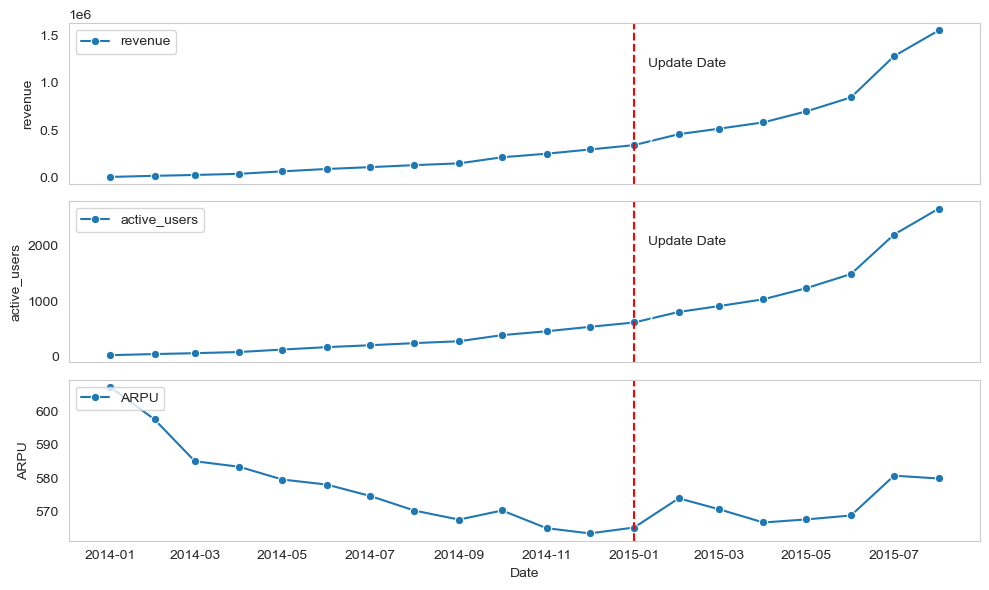

In [9]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
columns = ['revenue', 'active_users', 'ARPU']
for idx, col in enumerate(columns):
    sns.lineplot(data=monthly_stats, x=monthly_stats.index, y=monthly_stats[col], ax=ax[idx], marker='o')
    ax[idx].set_xlabel('Date')
    ax[idx].grid(False)
    ax[idx].axvline(x=new_version_launch.to_timestamp(), color='r', linestyle='--')
    ax[idx].legend([col], loc='upper left')
    ax[idx].annotate('Update Date', xy=(new_version_launch.to_timestamp(), 5), xytext=(10, 80), textcoords='offset points', 
                     arrowprops=dict(facecolor='black', arrowstyle='->'))
    
    # plt.grid(False)

plt.tight_layout()
plt.show()

Looking at the data we can see that revenue as well as active users and ARPU is growing steadily. ARPU was declining before the update, seems like it is picking up after the update. 

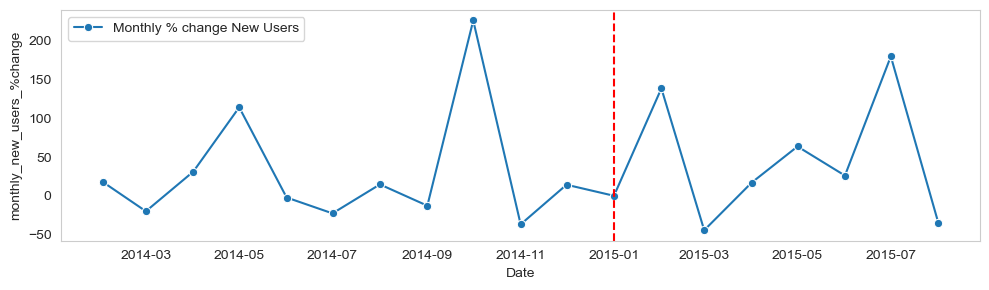

In [10]:
# Monthly % change in new users
monthly_new_users = df.groupby('registration_date')['user_id'].nunique().reset_index(name='new_users')

monthly_new_users.set_index(monthly_new_users['registration_date'].dt.to_timestamp(), inplace=True)
monthly_new_users['monthly_new_users_%change'] = monthly_new_users['new_users'].pct_change() * 100

# Ploting monthly % change of new users
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
sns.lineplot(data=monthly_new_users, x=monthly_new_users.index, y='monthly_new_users_%change', ax=ax, marker='o')
ax.set_xlabel('Date')
ax.grid(False)
ax.axvline(x=new_version_launch.to_timestamp(), color='r', linestyle='--')
ax.legend(['Monthly % change New Users'], loc='upper left')

# ax.annotate('Update Date', xy=(new_version_launch.to_timestamp(), 5), xytext=(10, 0), textcoords='offset points', 
#                      arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.tight_layout()
plt.show()

# Cohort analysis
\
Cohort analysis is performed to understand how different groups of users (cohorts), typically defined by their start date or another shared characteristic, behave over time.

In [11]:
df['cohort'] = df['registration_date']

# Group by cohort and reported_date (month) to see how cohorts evolve
cohort_data = (df.groupby(['cohort', 'reported_date'])['revenue']
                 .mean()
                 .reset_index())

cohort_data.head()

,cohort,reported_date,revenue
0,2014-01,2014-01,607.35
1,2014-01,2014-02,588.06
2,2014-01,2014-03,576.53
3,2014-01,2014-04,568.76
4,2014-01,2014-05,548.71


In [12]:
cohort_pivot = cohort_data.pivot(index='cohort', columns='reported_date', values='revenue')

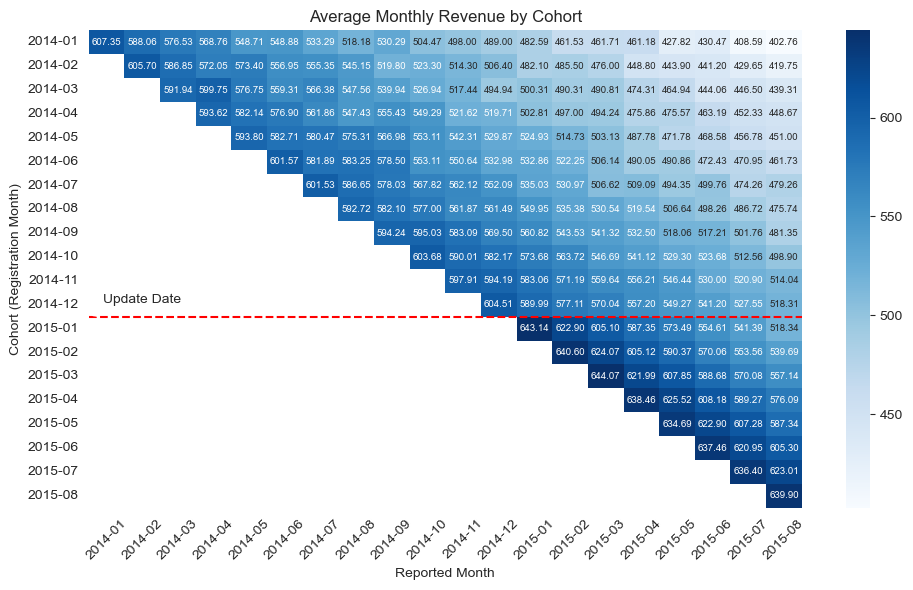

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(cohort_pivot, annot=True, fmt=".2f", cmap='Blues', annot_kws=dict(size=7))
plt.title('Average Monthly Revenue by Cohort')
plt.xlabel('Reported Month')
plt.ylabel('Cohort (Registration Month)')
plt.axhline(y=12, color='r', linestyle='--')
plt.annotate('Update Date', xy=(0, 12), xytext=(10, 10), textcoords='offset points', 
                     arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

---
This heatmap shows a classic cohort analysis of average monthly revenue by the month in which users first registered (cohort) and the months since they registered (reported months along the top). Each row represents a cohort (e.g., users who joined in January 2014 form the first row), and each column moving right shows how that same cohort performed in subsequent months. The cells are shaded based on average monthly revenue per user in that cohort during the given reported month. 

1. **Pre-Update Cohorts (Above the Red Line):** \
The cohorts from 2014-01 through 2014-12 show a certain pattern in first-month revenue. Typically, these earlier cohorts start at a certain revenue level in their first reported month and then decline over time. While the initial revenue levels vary, they generally hover around 600 (on the higher end for the earliest cohorts) and then gradually decrease as months pass.

2.	**Post-Update Cohorts (Below the Red Line):** \
After the update, look at the first reported month’s average revenue for the new cohorts that joined. The immediate stand-out is that the first-month average revenue per user for the cohort following the update line is noticeably higher—around the mid-600s—than the earlier cohorts’ first-month revenue, which were generally around the upper 500s or low 600s toward the end of the pre-update period. 

3.	**Significance of the Increase in First-Month Revenue:** \
The jump in first-month revenue per user after the update suggests that the product changes may have improved new user monetization. This could mean better onboarding, more compelling premium features, or an improved user experience that leads users to spend more in their initial month.

In [14]:
df['months_since_registration'] = (df['reported_date'] - df['registration_date']).apply(lambda x: x.n)
df['cohort'] = np.where(df['registration_date'] < new_version_launch, 'pre-update', 'post-update')
# Cohort-wise turnover by months since registration
cohort_turnover = df.groupby(['cohort', 'months_since_registration'])['revenue'].mean().reset_index()
cohort_turnover.head()

,cohort,months_since_registration,revenue
0,post-update,0,638.25
1,post-update,1,622.92
2,post-update,2,606.32
3,post-update,3,588.71
4,post-update,4,572.10


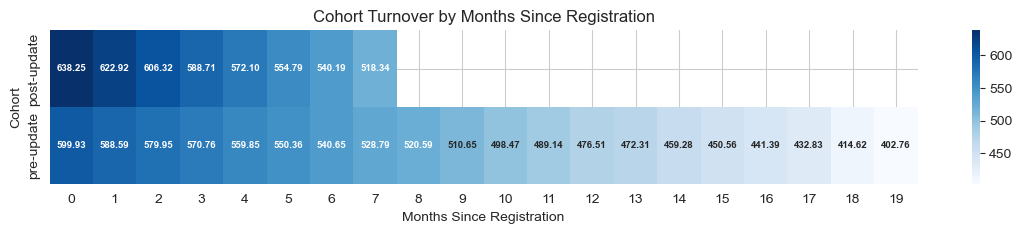

In [15]:
plt.figure(figsize=(14, 2))
sns.heatmap(cohort_turnover.pivot(index='cohort', columns='months_since_registration', values='revenue'), 
            cmap='Blues', annot=True, fmt=".2f", annot_kws={'size': 7, 'weight': 'bold'})
plt.title('Cohort Turnover by Months Since Registration')
plt.xlabel('Months Since Registration')
plt.ylabel('Cohort')
plt.show()

The post-update cohort (top row) starts with a substantially higher average turnover at month 0 (first month after registration) than the pre-update cohort (bottom row). For example, at month 0, the post-update cohort shows about 638.25 in turnover versus approximately 599.93 for the pre-update cohort. This suggests that the changes introduced in the update led to stronger initial monetization.
\
\
**Conclusions:** 

- The immediate and early-month revenue improvements suggest the update was successful in boosting initial user spending.
- If the pattern of higher turnover continues as the post-update cohort matures (once more data is available), it would confirm lasting positive impact.
- Further monitoring is needed to understand long-term retention and revenue sustainability. If the post-update cohort maintains its advantage, it indicates that the product changes not only drive short-term uplift but may also contribute to improved long-term user value.

In [16]:
df.groupby(['user_id', 'cohort'])['revenue'].mean().sort_values(ascending=False).to_frame().reset_index().groupby('cohort')['revenue'].mean()

cohort
post-update   621.07
pre-update    541.17
Name: revenue, dtype: float64

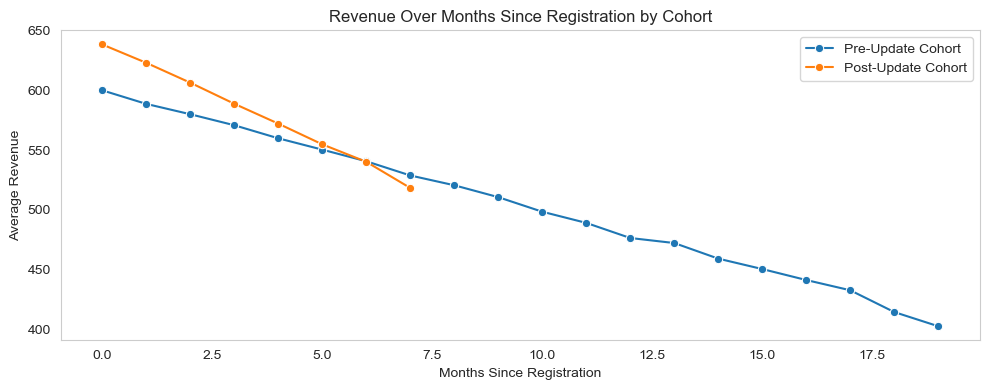

In [17]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=cohort_turnover[cohort_turnover['cohort'] == 'pre-update'], 
             x='months_since_registration', y='revenue', label='Pre-Update Cohort', marker='o')
sns.lineplot(data=cohort_turnover[cohort_turnover['cohort'] == 'post-update'], 
             x='months_since_registration', y='revenue', label='Post-Update Cohort', marker='o')
plt.title('Revenue Over Months Since Registration by Cohort')
plt.xlabel('Months Since Registration')
plt.ylabel('Average Revenue')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [18]:
pre_update_revenue_change = cohort_turnover[cohort_turnover['cohort'] == 'pre-update']['revenue'].pct_change().mean()*100
post_update_revenue_change = cohort_turnover[cohort_turnover['cohort'] == 'post-update']['revenue'].pct_change().mean()*100
print(f'Pre-Update Avg/Month Revenue Change: {pre_update_revenue_change:.2f}%')
print(f'Post-Update Avg/Month Revenue Change: {post_update_revenue_change:.2f}%')

Pre-Update Avg/Month Revenue Change: -2.07%
Post-Update Avg/Month Revenue Change: -2.93%


## Conclusion

The chart and the provided figures show how the average monthly revenue changes over time for both the Pre-Update and Post-Update cohorts. Here’s what the data suggests:

1. **Higher Initial Revenue for Post-Update Cohort:** \
Initially, the Post-Update cohort starts at a higher average revenue level than the Pre-Update cohort. This indicates that the product changes introduced after the update successfully boosted early user spending.
2. **Faster Decline for Post-Update Cohort:** \
Despite starting higher, the Post-Update cohort’s revenue declines at a slightly faster rate per month than the Pre-Update cohort (-2.93% vs. -2.07%). This steeper drop means that while initial monetization improved, these users’ spending habits decrease more quickly over time.
3. **Potential Explanations for the Faster Decline:** \
- Front-Loading of Revenue: It’s possible that the update encouraged users to spend more upfront, pulling future revenue into earlier months. As a result, the subsequent decline might appear steeper.
- Different User Behavior or Segments: The changes attracting higher initial spending might also bring in users who don’t stick around or continue spending at high levels in later months.
- Need for Retention Improvements: The product might need additional features or strategies to retain these higher-spending users and prevent such a rapid decrease over time.
4. **Contextualization Matters:** \
Even though the Post-Update cohort is declining faster, starting from a higher initial revenue point may still result in equal or greater total revenue over the first few months. Over the long term, however, sustaining revenue depends on mitigating that steeper decline, focusing on retention, and encouraging consistent user spending habits.

\
**Conclusion:** \
The update improved initial revenue generation but also introduced a pattern where user spending tapers off more quickly. To fully capitalize on the initial gains, the next steps would be understanding why users are dropping off faster and implementing strategies to slow that decline, thereby maximizing both initial and long-term revenue.